In [45]:
import os
spark_home=os.environ.get('SPARK_HOME',None)
print(spark_home)
import os
java_home=os.environ.get('JAVA_HOME',None)
print(java_home)
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64/jre"
import sys
sys.path

None
/usr/lib/jvm/java-8-openjdk-amd64/jre


['/home/shared/mo/HFclusters/dependencies/CPRD',
 '/home/shared/mo/HFclusters/dependencies/sparkDeletable/spark-3e222393-73d2-412c-be68-c58dd5f7d4fa/userFiles-ed161b18-2d2a-4794-be4e-656ba30c3ee6',
 '/home/shared/mo/HFclusters/dependencies',
 '/home/mo/anaconda3/envs/cprd/lib/python37.zip',
 '/home/mo/anaconda3/envs/cprd/lib/python3.7',
 '/home/mo/anaconda3/envs/cprd/lib/python3.7/lib-dynload',
 '',
 '/home/mo/anaconda3/envs/cprd/lib/python3.7/site-packages',
 '/home/mo/anaconda3/envs/cprd/lib/python3.7/site-packages/IPython/extensions',
 '/home/mo/.ipython']

In [2]:
import itertools
import pandas as pd
import numpy as np
import sys 
import datetime
sys.path.insert(0, '/home/shared/mo/HFclusters/dependencies/CPRD')


from utils.yaml_act import yaml_load
from utils.arg_parse import arg_paser
from CPRD.config.spark import spark_init, read_parquet, read_txt, read_csv
import pyspark.sql.functions as F
from pyspark.sql.types import StructType,StructField, StringType, DateType
from CPRD.functions import tables, merge, cohort_select,risk_prediction, modalities, MedicalDictionary, risk_prediction, predictor_extractor
from pyspark.sql import Window
import matplotlib.pyplot as plt
import seaborn as sns
from lifelines import KaplanMeierFitter
import warnings
import miceforest as mf
import copy

from pyspark.sql.types import IntegerType, DoubleType
from pyspark.ml.feature import StringIndexer
from sklearn.calibration import calibration_curve, CalibrationDisplay

warnings.filterwarnings("ignore")

class dotdict(dict):
    """dot.notation access to dictionary attributes"""
    __getattr__ = dict.get
    __setattr__ = dict.__setitem__
    __delattr__ = dict.__delitem__


Bad key savefig.frameon in file /home/mo/anaconda3/envs/cprd/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle, line 421 ('savefig.frameon : True')
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.4.3/matplotlibrc.template
or from the matplotlib source distribution

Bad key verbose.level in file /home/mo/anaconda3/envs/cprd/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle, line 472 ('verbose.level  : silent      # one of silent, helpful, debug, debug-annoying')
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.4.3/matplotlibrc.template
or from the matplotlib source distribution

Bad key verbose.fileo in file /home/mo/anaconda3/envs/cprd/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle, line 473 ('verbose.fileo  : sys.stdout  # a log filename, sys.stdout or sys.stderr')
You probab

In [3]:
def ohe_pretty(df,column):
    distinct_values = df.select(column)\
                    .distinct()\
                    .rdd\
                    .flatMap(lambda x: x).collect()
    for distinct_value in distinct_values:
        function = F.udf(lambda item: 
                       1 if item == distinct_value else 0, 
                       IntegerType())
        try:
            new_column_name = column+'_'+distinct_value
        except: 
            print('Error: column value is '+str(column)+' and distinct_value is: '+str(distinct_value))
        df = df.withColumn(new_column_name, function(F.col(column)))
    return df

In [4]:
args = dotdict({'params': '/home/shared/mo/HFclusters/dependencies/CPRD/config/config.yaml'})
params = yaml_load(args.params)
params['pyspark']={'temp':'/home/shared/mo/HFclusters/dependencies/sparkDeletable',
                   'pyspark_env':'/home/mo/anaconda3/envs/cprd/bin/python3.7'}
spark_params = params['pyspark']
spark = spark_init(spark_params)
file = params['file_path']
# data_params = params['params']1

2022-11-24 10:49:58 WARN  Utils:66 - Your hostname, deepmedicine resolves to a loopback address: 127.0.1.1; using 163.1.176.44 instead (on interface enp4s0)
2022-11-24 10:49:58 WARN  Utils:66 - Set SPARK_LOCAL_IP if you need to bind to another address
2022-11-24 10:49:59 WARN  NativeCodeLoader:62 - Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


2022-11-24 10:49:59 WARN  SparkConf:66 - Note that spark.local.dir will be overridden by the value set by the cluster manager (via SPARK_LOCAL_DIRS in mesos/standalone/kubernetes and LOCAL_DIRS in YARN).


In [5]:
path_trials="/home/shared/mo/HFclusters/dependencies/emulated_trials_parquets/Trial_Aldosterone/"
paths_trials=[path[0] for path in os.walk(path_trials)]
paths_trials.remove(path_trials)
paths_trials.remove("/home/shared/mo/HFclusters/dependencies/emulated_trials_parquets/Trial_Aldosterone/.ipynb_checkpoints")
paths_trials=[path+"/part-*.parquet" for path in paths_trials]

In [549]:
df=spark.sqlContext.read.parquet(*paths_trials).coalesce(30).cache()

2022-11-26 10:24:56 WARN  CacheManager:66 - Asked to cache already cached data.


In [550]:
continous_vars=['BMI','HR','Systolic_BP','Haemoglobin','Potassium']
df.select(continous_vars).select([F.count(F.when(F.isnan(c) | F.col(c).isNull(), c)).alias(c) for c in continous_vars]
   ).show()

+------+------+-----------+-----------+---------+
|   BMI|    HR|Systolic_BP|Haemoglobin|Potassium|
+------+------+-----------+-----------+---------+
|122960|215035|      28883|      93470|    68694|
+------+------+-----------+-----------+---------+



In [551]:
#df.agg({'Treatment':'sum'}).show()

In [552]:
#df.select([F.count(F.when(F.col(c)!=0 , c)).alias(c) for c in df.columns]).toPandas().squeeze()

In [553]:
def calculate_bounds(df):
    bounds = {c: dict(zip(["q1", "q3"], df.approxQuantile(c, [0.25, 0.75], 0))) for c,d in zip(df.columns, df.dtypes) if d[1] == "double"}

    for c in bounds:
        iqr = bounds[c]['q3'] - bounds[c]['q1']
        bounds[c]['min'] = bounds[c]['q1'] - (iqr * 1.5)
        bounds[c]['max'] = bounds[c]['q3'] + (iqr * 1.5)

    return bounds

def outlierremoval(df,cols):
    bounds = calculate_bounds(df.select(cols))

    col_dict={col:col+"_outlier" for col in cols}

    for col in cols:
        df=df.withColumn(col_dict[col],F.when((F.col(col)>bounds[col]["max"]) | (F.col(col)<bounds[col]["min"]),1).otherwise(0))

    df.select(list(col_dict.values())).groupBy().sum().show()

    for col in cols:
        df=df.withColumn(col,F.when(F.col(col_dict[col])==1,F.lit(None)).otherwise(F.col(col)))
    
    df=df.drop(*list(col_dict.values()))
    
    return df

In [554]:
df=outlierremoval(df,continous_vars)

+----------------+---------------+------------------------+------------------------+----------------------+
|sum(BMI_outlier)|sum(HR_outlier)|sum(Systolic_BP_outlier)|sum(Haemoglobin_outlier)|sum(Potassium_outlier)|
+----------------+---------------+------------------------+------------------------+----------------------+
|            3220|            145|                    1957|                    5097|                  4241|
+----------------+---------------+------------------------+------------------------+----------------------+



In [555]:
# Imputation

0 BMI
1 HR
2 Systolic_BP
3 Haemoglobin
4 Potassium


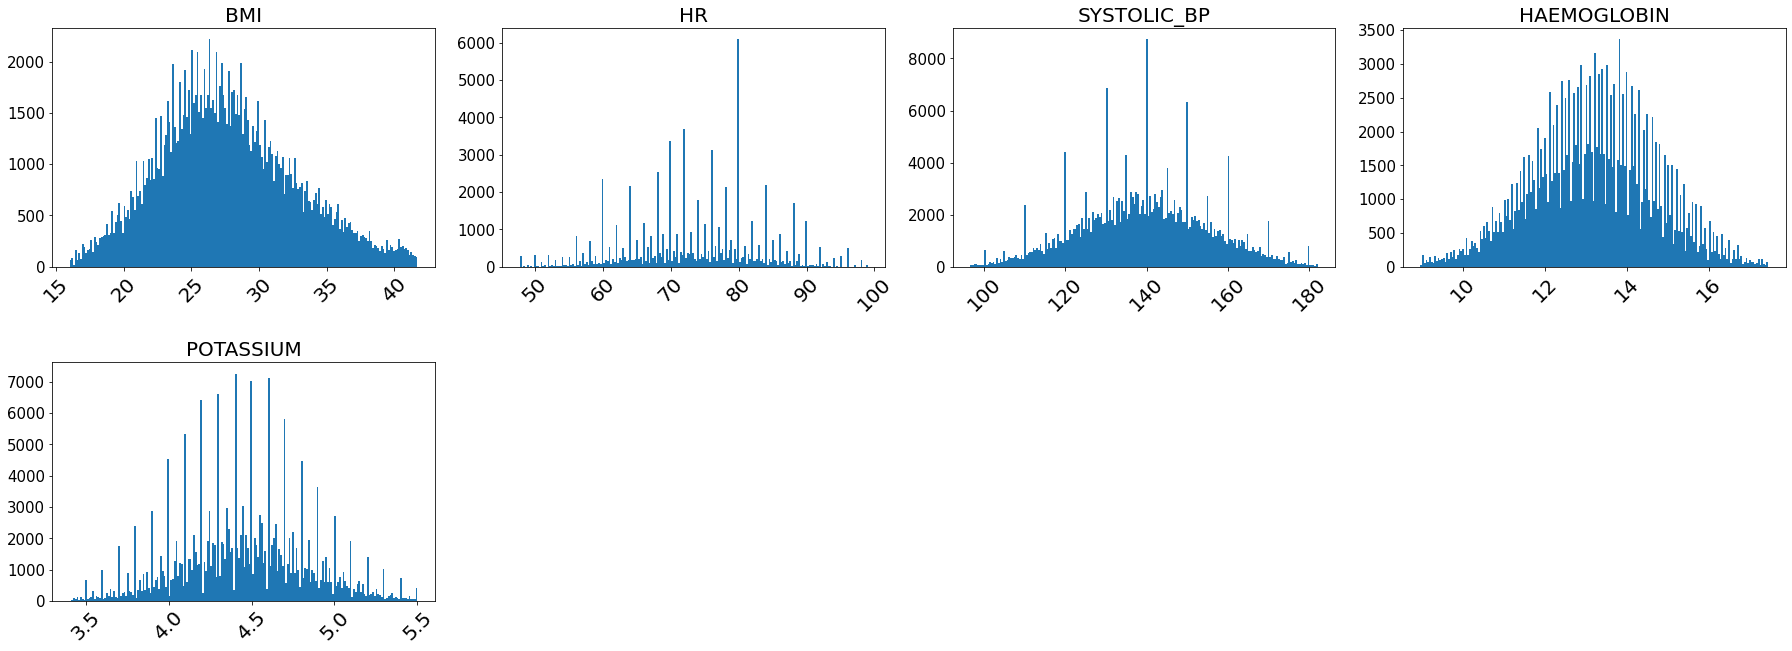

In [556]:
fig=plt.figure(figsize=(25,15))
for num,col in enumerate(continous_vars):
    ax=fig.add_subplot(3,4,num+1)
    pdf_temp=df.select(col).where(F.col(col).isNotNull()).toPandas()
    ax.hist(pdf_temp[col],bins=200)
    plt.xticks(rotation=45,fontsize=20)
    plt.yticks(fontsize=15)
    plt.title(col.upper(),fontsize=20)
    print(num,col)
plt.tight_layout()
fig.subplots_adjust(top=0.85,hspace=0.4)
plt.show()


In [557]:
"""
from pyspark.ml.feature import VectorAssembler

features=[col for col in df.columns if (col not in ["Trial_date",'end_of_followup_subtrial','died','patid','Treatment'])] 

assembler=VectorAssembler()\
.setInputCols(features)\
.setOutputCol('Vectorised_features')

data=assembler.transform(df).cache()#.select('patid','Vectorised_features','Treatment')
"""

'\nfrom pyspark.ml.feature import VectorAssembler\n\nfeatures=[col for col in df.columns if (col not in ["Trial_date",\'end_of_followup_subtrial\',\'died\',\'patid\',\'Treatment\'])] \n\nassembler=VectorAssembler().setInputCols(features).setOutputCol(\'Vectorised_features\')\n\ndata=assembler.transform(df).cache()#.select(\'patid\',\'Vectorised_features\',\'Treatment\')\n'

In [558]:
pdf=df.toPandas()
pdf['Year']=pdf.Trial_date.map(lambda x:x[:4]).astype(int)
pdf=pdf.rename(columns={"Time_since_HF_diagnosis_[yrs]":"Time_since_HF_diagnosis_yrs"})

In [559]:
pdf.columns

Index(['patid', 'ACE', 'Amiloride', 'Anticoagulant', 'Antiplatelet', 'ARB',
       'BB', 'Digoxin', 'Diuretic', 'Nitrates', 'Statins', 'Smoking_status_1',
       'Smoking_status_2', 'Smoking_status_Null', 'Alcohol_consumption_1',
       'Alcohol_consumption_2', 'Alcohol_consumption_Null', 'HF_type_HF-REF',
       'HF_type_Null', 'NYHA_class_51214', 'NYHA_class_13189',
       'NYHA_class_19066', 'NYHA_class_Null', 'BMI', 'HR', 'Systolic_BP',
       'Haemoglobin', 'Potassium', 'Cancer', 'Mental_or_behavioral_disorder',
       'Musculoskeletal_or_connective_tissue_diagnosis', 'pacemaker',
       'heart_valve_surgery', 'aortic_stenosis',
       'percutaneous_coronary_intervention', 'coronary_artery_bypass_graft',
       'any_severe_bleed_except_intracranial', 'dialysis', 'lung_disease',
       'alcoholism', 'hypertension', 'diabetes', 'IBD',
       'myocardial_infarction', 'peripheral_arterial_disease',
       'atrial_fibrillation', 'ischaemic_stroke_or_transient_attack', 'gout',
       'A

In [571]:
pdf.end_of_followup_subtrial

0         2008-10-01
1         2008-02-11
2         2008-10-01
3         2008-10-01
4         2008-03-16
             ...    
288473    2009-07-01
288474    2009-07-01
288475    2009-07-01
288476    2009-07-01
288477    2009-07-01
Name: end_of_followup_subtrial, Length: 288478, dtype: object

In [560]:
kds = mf.ImputationKernel(
  pdf.drop(columns=["NYHA_class_51214","Trial_date",'end_of_followup_subtrial','died','patid','Treatment']),#variable_schema={"BMI"},
  save_all_iterations=True,
  random_state=1991,
)

kds.mice(5)
pdf_imp= kds.complete_data(0)

0 BMI
1 HR
2 Systolic_BP
3 Haemoglobin
4 Potassium


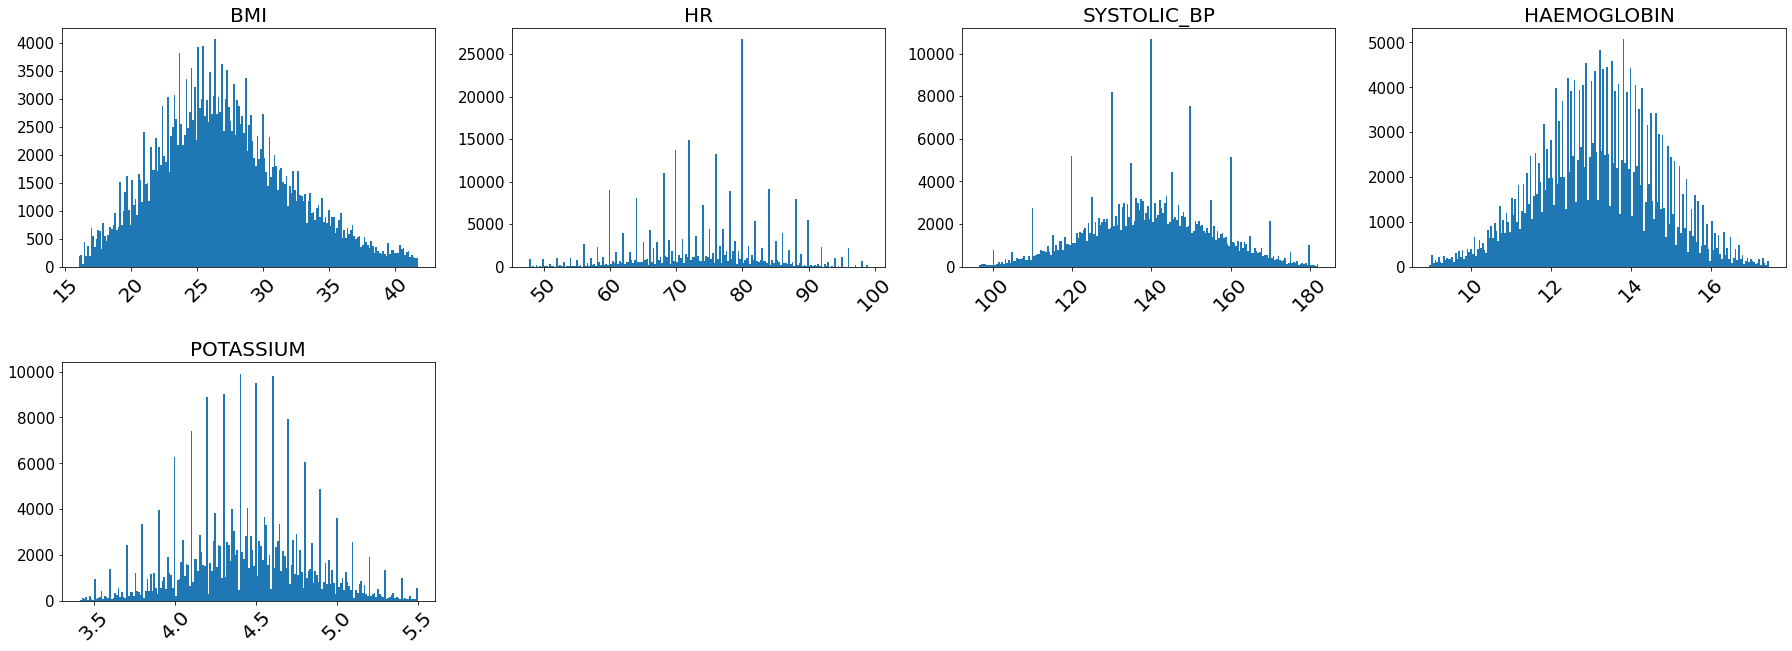

In [561]:
fig=plt.figure(figsize=(25,15))
for num,col in enumerate(continous_vars):
    ax=fig.add_subplot(3,4,num+1)
    ax.hist(pdf_imp[col],bins=200)
    plt.xticks(rotation=45,fontsize=20)
    plt.yticks(fontsize=15)
    plt.title(col.upper(),fontsize=20)
    print(num,col)
plt.tight_layout()
fig.subplots_adjust(top=0.85,hspace=0.4)
plt.show()

AxesSubplot(0.125,0.125;0.62x0.755)


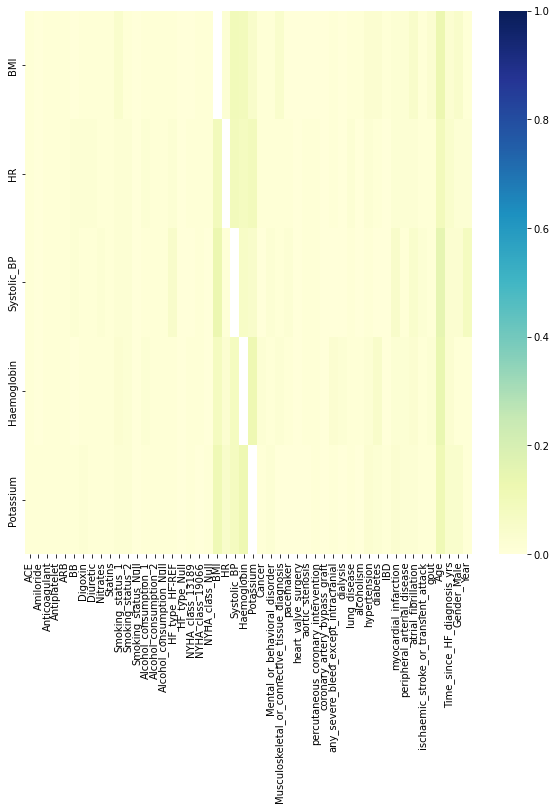

In [562]:
fig=plt.figure(figsize=(10,10))
kds.plot_feature_importance(dataset=0, annot=False,cmap="YlGnBu",vmin=0, vmax=1)

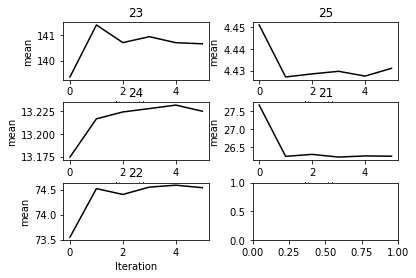

In [563]:
kds.plot_mean_convergence(wspace=0.3, hspace=0.4)

In [564]:
pdf_imp=pdf_imp.join(pdf[['Trial_date','patid']])

In [565]:
df_imp=spark.sqlContext.createDataFrame(pdf_imp[['Trial_date','patid']+continous_vars])

df_imp=df_imp.withColumnRenamed('BMI','BMI_imp').withColumnRenamed('HR','HR_imp').withColumnRenamed('Systolic_BP','Systolic_BP_imp')\
.withColumnRenamed('Haemoglobin','Haemoglobin_imp').withColumnRenamed('Potassium','Potassium_imp')

df=df.join(df_imp,on=['patid','Trial_date'],how="left").cache()
df=df.drop(*continous_vars)

mapping = {col+"_imp":col for col in continous_vars}
df=df.select([F.col(c).alias(mapping.get(c, c)) for c in df.columns])

rdd=df.rdd.map(lambda x: 
    (x["patid"],x["Trial_date"],x["Trial_date"][:4])
    ) 
df_temp=rdd.toDF(["patid","Trial_date","Trial_year"])
df=df.join(df_temp,on=['patid','Trial_date'],how="left").cache()

df=df.join(ohe_pretty(df.select(["patid","Trial_date","Trial_year"]),"Trial_year")\
           .drop(*["Trial_year","Trial_year_2000"]),on=["patid","trial_date"],how='left')

2022-11-26 10:26:38 WARN  TaskSetManager:66 - Stage 2080 contains a task of very large size (273 KB). The maximum recommended task size is 100 KB.


In [566]:
#df.toPandas().head().T

In [567]:
from pyspark.ml.feature import VectorAssembler

features=[col for col in df.columns if (col not in ['end_of_followup_subtrial','died','patid','Treatment',"Trial_date","Trial_year"])] 

assembler=VectorAssembler()\
.setInputCols(features)\
.setOutputCol('Vectorised features')

data=assembler.transform(df).select('patid','Vectorised features','Treatment','Trial_date','end_of_followup_subtrial','died').cache()

data.show()

+--------+--------------------+---------+----------+------------------------+----+
|   patid| Vectorised features|Treatment|Trial_date|end_of_followup_subtrial|died|
+--------+--------------------+---------+----------+------------------------+----+
|10031111|(54,[15,21,23,24,...|        0|2004-01-01|              2008-06-30|   0|
|10054549|(54,[11,13,16,21,...|        0|2004-10-01|              2009-10-01|   0|
|10059586|(54,[0,11,13,21,2...|        0|2002-02-01|              2007-02-01|   0|
|10072339|(54,[10,13,21,23,...|        0|2002-01-01|              2004-06-25|   1|
|10079454|(54,[0,2,3,5,9,13...|        0|2004-07-01|              2009-07-01|   0|
|10098027|(54,[2,4,5,6,7,8,...|        0|2004-05-01|              2009-05-01|   0|
|10118416|(54,[0,3,7,8,9,13...|        0|2002-10-01|              2007-10-01|   0|
|10124006|(54,[11,13,21,24,...|        0|2000-10-01|              2005-10-01|   0|
|10124006|(54,[11,13,21,24,...|        0|2001-07-01|              2006-07-01|   0|
|101

In [568]:
#df.select([F.count(F.when(F.col(c).isNull() , c)).alias(c) for c in df.columns]).toPandas().squeeze()

In [569]:
from pyspark.ml.classification import LogisticRegression
from pyspark.mllib.evaluation import BinaryClassificationMetrics
lr=LogisticRegression(featuresCol='Vectorised features',labelCol='Treatment',maxIter=10,regParam=0,elasticNetParam=0,threshold=0.5)
lrModel=lr.fit(data)

In [570]:
predictions=lrModel.transform(data).cache()
preds = predictions.select('patid','Treatment','probability','Trial_date','end_of_followup_subtrial','died').rdd\
.map(lambda row: (int(row['patid']),
                  float(row['probability'][1]),
                  int(row['Treatment']),
                  str(row['Trial_date']),
                  str(row['end_of_followup_subtrial']),
                  int(row['died'])
                 )
    )
pdf_temp=preds.toDF().toPandas().rename(columns={"_1":'patid',"_2":"propensity","_3":'treatment',"_4":"trial_startdate","_5":"trial_enddate","_6":'died'})

In [246]:
pdf_temp["trial_duration_months"]=(pd.to_datetime(pdf_temp.trial_enddate,format="%Y-%m-%d")-pd.to_datetime(pdf_temp.trial_startdate,format="%Y-%m-%d"))/np.timedelta64(1, 'M')
pdf_temp["trial_duration_months"]=pdf_temp["trial_duration_months"].astype(int)

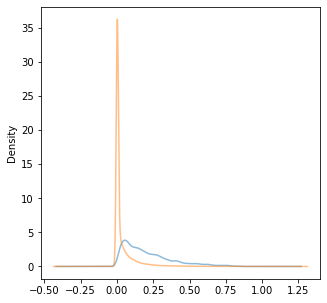

In [247]:
fig,ax=plt.subplots(figsize=(5,5))
pdf_temp[pdf_temp.treatment==1].propensity.plot.kde(bw_method=0.1,ax=ax,alpha=0.5)
pdf_temp[pdf_temp.treatment==0].propensity.plot.kde(bw_method=0.1,ax=ax,alpha=0.5)
plt.show()

In [248]:
"""
class CurveMetrics(BinaryClassificationMetrics):
    def __init__(self, *args):
        super(CurveMetrics, self).__init__(*args)

    def _to_list(self, rdd):
        points = []
        # Note this collect could be inefficient for large datasets 
        # considering there may be one probability per datapoint (at most)
        # The Scala version takes a numBins parameter, 
        # but it doesn't seem possible to pass this from Python to Java
        for row in rdd.collect():
            # Results are returned as type scala.Tuple2, 
            # which doesn't appear to have a py4j mapping
            points += [(float(row._1()), float(row._2()))]
        return points

    def get_curve(self, method):
        rdd = getattr(self._java_model, method)().toJavaRDD()
        return self._to_list(rdd)

metrics = CurveMetrics(preds)
#metrics.get_curve('fMeasureByThreshold')
#metrics.get_curve('precisionByThreshold')
#metrics.get_curve('recallByThreshold')

# Returns as a list (false positive rate, true positive rate)
#points = CurveMetrics(preds).get_curve('roc')

plt.figure()
x_val = [x[0] for x in points]
y_val = [x[1] for x in points]
plt.title("ROC")
plt.xlabel("False Positive")
plt.ylabel("True Positive Rate")
plt.plot(x_val, y_val)

print('AUPRC: {:.4f}, AUROC: {:.4f}'.format(metrics.areaUnderPR,metrics.areaUnderROC))
"""

'\nclass CurveMetrics(BinaryClassificationMetrics):\n    def __init__(self, *args):\n        super(CurveMetrics, self).__init__(*args)\n\n    def _to_list(self, rdd):\n        points = []\n        # Note this collect could be inefficient for large datasets \n        # considering there may be one probability per datapoint (at most)\n        # The Scala version takes a numBins parameter, \n        # but it doesn\'t seem possible to pass this from Python to Java\n        for row in rdd.collect():\n            # Results are returned as type scala.Tuple2, \n            # which doesn\'t appear to have a py4j mapping\n            points += [(float(row._1()), float(row._2()))]\n        return points\n\n    def get_curve(self, method):\n        rdd = getattr(self._java_model, method)().toJavaRDD()\n        return self._to_list(rdd)\n\nmetrics = CurveMetrics(preds)\n#metrics.get_curve(\'fMeasureByThreshold\')\n#metrics.get_curve(\'precisionByThreshold\')\n#metrics.get_curve(\'recallByThreshold\

Text(0.5, 1.0, 'Calibration plot')

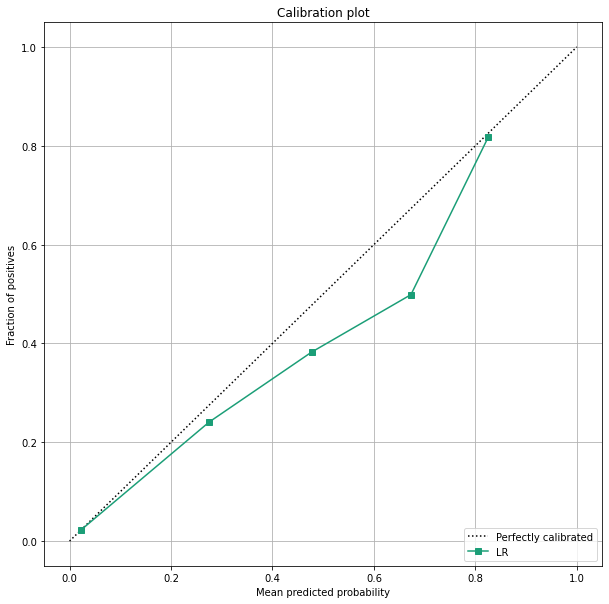

In [249]:
fig = plt.figure(figsize=(10, 10))
colors = plt.cm.get_cmap("Dark2")

ax_calibration_curve = fig.add_subplot()

display = CalibrationDisplay.from_predictions(pdf_temp.treatment,pdf_temp.propensity,n_bins=5,name="LR",
    ax=ax_calibration_curve,
    color=colors(0))

ax_calibration_curve.grid()
ax_calibration_curve.set_title("Calibration plot")

(0.0, 200.0)

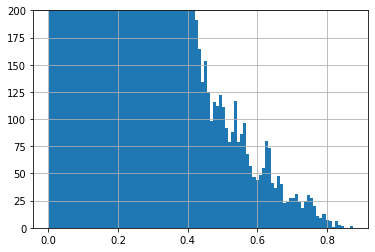

In [250]:
fig,ax=plt.subplots()
pdf_temp.propensity.hist(bins=100,ax=ax)
ax.set_ylim(0,200)

In [504]:
# Overlap Trimming {https://jamanetwork.com/journals/jama/fullarticle/2765748} and Sturmer trimming {https://www.ncbi.nlm.nih.gov/pmc/articles/PMC8327194/}

In [131]:
sturmer=(np.percentile(pdf_temp[pdf_temp.treatment==1].propensity,5),np.percentile(pdf_temp[pdf_temp.treatment==0].propensity,95))
sturmer

(0.022521706499796706, 0.17443106612102227)

In [148]:
print('The percentage of positive labels (treated) trimmed is %{:.4f}'.format(
    pdf_temp[((pdf_temp.propensity<sturmer[0]) | (pdf_temp.propensity>sturmer[1])) & (pdf_temp.treatment==1)].shape[0]/pdf_temp[(pdf_temp.treatment==1)].shape[0]*100))

print('The percentage of negative labels (untreated) trimmed is %{:.4f}'.format(
    pdf_temp[((pdf_temp.propensity<sturmer[0]) | (pdf_temp.propensity>sturmer[1])) & (pdf_temp.treatment==0)].shape[0]/pdf_temp[(pdf_temp.treatment==0)].shape[0]*100))


The percentage of positive labels (treated) trimmed is %51.6285
The percentage of negative labels (untreated) trimmed is %77.7619


# IPTW with strumer trimming

## Refit propensity model

In [152]:
pdf_strumer_trimmed=pdf_temp[~((pdf_temp.propensity<sturmer[0]) | (pdf_temp.propensity>sturmer[1]))]
pdf_strumer_trimmed.rename(columns={"trial_startdate":"Trial_date"},inplace=True)

In [199]:
df_strumer_trimmed_cohort=spark.sqlContext.createDataFrame(pdf_strumer_trimmed[["patid","Trial_date"]])

In [211]:
data_trimmed=data.join(df_strumer_trimmed_cohort,on=['patid','Trial_date'],how="right").cache()

In [469]:
lr_trimmed=LogisticRegression(featuresCol='Vectorised features',labelCol='Treatment',maxIter=10,regParam=0,elasticNetParam=0,threshold=0.50)
lrModel_trimmed=lr.fit(data_trimmed)

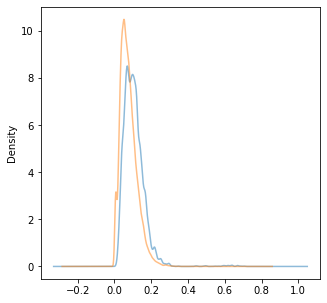

In [470]:
predictions_trimmed=lrModel_trimmed.transform(data_trimmed).cache()
preds_trimmed = predictions_trimmed.select('patid','Treatment','probability','Trial_date','end_of_followup_subtrial','died').rdd\
.map(lambda row: (int(row['patid']),
                  float(row['probability'][1]),
                  int(row['Treatment']),
                  str(row['Trial_date']),
                  str(row['end_of_followup_subtrial']),
                  int(row['died'])
                 )
    )
pdf_temp_trimmed=preds_trimmed.toDF().toPandas().rename(columns={"_1":'patid',"_2":"propensity","_3":'treatment',"_4":"trial_startdate","_5":"trial_enddate","_6":'died'})
pdf_temp_trimmed["trial_duration_months"]=(pd.to_datetime(pdf_temp_trimmed.trial_enddate,format="%Y-%m-%d")-pd.to_datetime(pdf_temp_trimmed.trial_startdate,format="%Y-%m-%d"))/np.timedelta64(1, 'M')
pdf_temp_trimmed["trial_duration_months"]=pdf_temp_trimmed["trial_duration_months"].astype(int)

fig,ax=plt.subplots(figsize=(5,5))
pdf_temp_trimmed[pdf_temp_trimmed.treatment==1].propensity.plot.kde(bw_method=0.1,ax=ax,alpha=0.5)
pdf_temp_trimmed[pdf_temp_trimmed.treatment==0].propensity.plot.kde(bw_method=0.1,ax=ax,alpha=0.5)
plt.show()

Text(0.5, 1.0, 'Calibration plot')

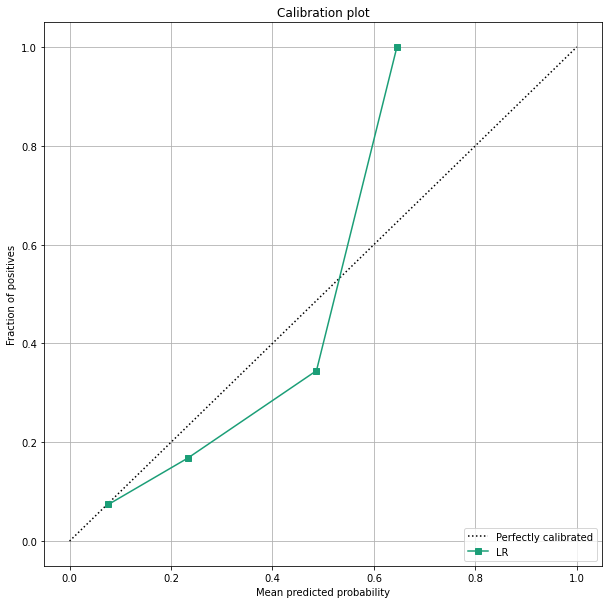

In [471]:
fig = plt.figure(figsize=(10, 10))
colors = plt.cm.get_cmap("Dark2")

ax_calibration_curve = fig.add_subplot()

display = CalibrationDisplay.from_predictions(pdf_temp_trimmed.treatment,pdf_temp_trimmed.propensity,n_bins=5,name="LR",
    ax=ax_calibration_curve,
    color=colors(0))

ax_calibration_curve.grid()
ax_calibration_curve.set_title("Calibration plot")

# population characteristics

In [687]:
def _prepare_data_for_ST(pdf,var,preparation):
    processes=preparation.split("_")
    string=""
    for p in processes:
        if p=='ms':
            string+="{var1:0.2f} \u00B1 {var2:0.2f}".format(var1=pdf[var].mean(),var2=pdf[var].std())
        if p=='c':
            string+="{var1:0.0f} ".format(var1=pdf[pdf[var]!=0].shape[0])
        if p=='p':
            string+="(%{var1:0.2f})".format(var1=pdf[pdf[var]!=0].shape[0]/pdf.shape[0]*100)
        if p=='pmis':
            string+=" ({var1:0.2f}%)".format(var1=pdf[var].notnull().sum()/pdf.shape[0]*100)
            
    return string

def create_summary_table_custom(pdf, variable_dict=None,split_by_col=None):
    """"
    1.create a nested dictionary similar to above
    2.use the following processing types for each variable
    "ms": mean and standard deviation
    c: count
    p: percentage of nonzeros in the population
    pmis: percentage of missing values
    3.cascade operations with an underline e.g.  'BMI':'ms_pmis'
    """
    if split_by_col is None:
        sum_dict={"n":pdf.shape[0]}

        for k,v in variable_dict.items():
            sum_dict[k]="*********"
            for k_,v_ in v.items():
                sum_dict[k_]=_prepare_data_for_ST(pdf,k_,v_)
               
        sum_table=pd.DataFrame(data=sum_dict,index=[0])
    
    else:
        index=pdf[pdf[split_by_col]==0].index
        sum_table=pd.concat([create_summary_table_custom(pdf.iloc[index],variable_dict=variable_dict),
                   create_summary_table_custom(pdf.iloc[pdf.index.difference(index)],variable_dict=variable_dict)],axis=0)
        
    return sum_table

In [688]:
comorbidities=['Cancer', 'Mental_or_behavioral_disorder',
       'Musculoskeletal_or_connective_tissue_diagnosis', 'pacemaker',
       'heart_valve_surgery', 'aortic_stenosis',
       'percutaneous_coronary_intervention', 'coronary_artery_bypass_graft',
       'any_severe_bleed_except_intracranial', 'dialysis', 'lung_disease',
       'alcoholism', 'hypertension', 'diabetes', 'IBD',
       'myocardial_infarction', 'peripheral_arterial_disease',
       'atrial_fibrillation', 'ischaemic_stroke_or_transient_attack', 'gout']
behavioural=['Smoking_status_1', 'Smoking_status_2', 'Smoking_status_Null', 'Alcohol_consumption_1', 'Alcohol_consumption_2', 'Alcohol_consumption_Null']
meds=['ACE', 'Amiloride', 'Anticoagulant', 'Antiplatelet', 'ARB','BB', 'Digoxin', 'Diuretic', 'Nitrates', 'Statins']
hf_phenos=['HF_type_HF-REF',
       'HF_type_Null', 'NYHA_class_51214', 'NYHA_class_13189',
       'NYHA_class_19066', 'NYHA_class_Null']

variable_dict={"Demographics":{"Age":"ms",
                               "Gender_Male":"c_p",
                              "died":"c_p"},
               "HF phenotypes":{**{"Time_since_HF_diagnosis_yrs":"ms"},**{var:"c_p" for var in hf_phenos}},
               "Behavioural":{var:"c_p" for var in behavioural},
               "Physiological":{'Potassium':'ms_pmis',
                                'BMI':'ms_pmis',
                                'HR':'ms_pmis',
                                'Systolic_BP':'ms_pmis', 
                                'Haemoglobin':'ms_pmis'},
               "Comorbidities":{comorbidity:"c_p" for comorbidity in comorbidities},
               "Medications":{var:"c_p" for var in meds}
              }

create_summary_table_custom(pdf,variable_dict=variable_dict,split_by_col='Treatment').T

,0,0
n,277947,10531
Demographics,*********,*********
Age,76.18 ± 9.98,75.16 ± 9.78
Gender_Male,132972 (%47.84),5777 (%54.86)
died,75685 (%27.23),3942 (%37.43)
HF phenotypes,*********,*********
Time_since_HF_diagnosis_yrs,2.85 ± 2.27,2.30 ± 2.16
HF_type_HF-REF,32544 (%11.71),2251 (%21.37)
HF_type_Null,387 (%0.14),12 (%0.11)
NYHA_class_51214,71 (%0.03),20 (%0.19)


# Survival curves and HR

In [473]:
from lifelines import KaplanMeierFitter

In [493]:
ix = pdf_temp_trimmed['treatment'] == 0
pdf_temp_trimmed['iptw'].loc[ix]=1./(1-pdf_temp_trimmed.loc[ix]['propensity'])
pdf_temp_trimmed['iptw'].loc[~ix]=1./(pdf_temp_trimmed.loc[~ix]['propensity'])

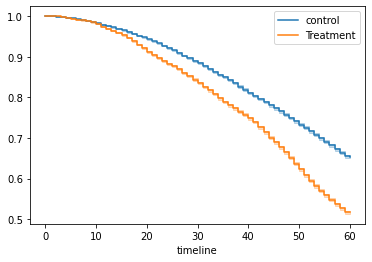

In [494]:


ax = plt.subplot(111)

kmf_control = KaplanMeierFitter()
ax = kmf_control.fit(pdf_temp_trimmed.loc[ix]['trial_duration_months'], pdf_temp_trimmed.loc[ix]['died'],weights=pdf_temp_trimmed.loc[ix]['iptw'], label='control').plot_survival_function(ax=ax)

kmf_treatment = KaplanMeierFitter()
ax = kmf_treatment.fit(pdf_temp_trimmed.loc[~ix]['trial_duration_months'], pdf_temp_trimmed.loc[~ix]['died'],weights=pdf_temp_trimmed.loc[~ix]['iptw'], label='Treatment').plot_survival_function(ax=ax)

plt.show()

In [505]:
pdf_cox=pd.merge(pdf_imp,pdf_temp_trimmed[["patid","trial_startdate",'iptw','died','treatment','trial_duration_months','propensity']],on=['patid','trial_startdate'],how='right')

from sklearn.preprocessing import OneHotEncoder
encoder = OneHotEncoder(handle_unknown='error')
results=encoder.fit_transform(pdf_cox[['Year']]).toarray()

encoder_df = pd.DataFrame(results,columns=encoder.categories_).astype(int)

pdf_cox=pd.concat([pdf_cox,encoder_df],axis=1).rename(columns={col:"Year_"+str(col[0]) for col in encoder_df.columns})\
.drop(columns=["Year_2000","Year"])

In [548]:
from lifelines import CoxPHFitter

cph=CoxPHFitter(penalizer=0.01, l1_ratio=1.0) #& (pdf_cox["Time_since_HF_diagnosis_yrs"]>0) & (pdf_cox["Time_since_HF_diagnosis_yrs"]<2)
cph.fit(pdf_cox[(pdf_cox['HF_type_HF-REF']==0)].\
        drop(columns=["Smoking_status_Null","iptw",
                      "trial_startdate","patid",
                      "coronary_artery_bypass_graft","dialysis",
                      "HF_type_HF-REF",'HF_type_Null',
                      "Alcohol_consumption_1","Alcohol_consumption_2","Alcohol_consumption_Null"]),duration_col='trial_duration_months',event_col='died')
cph.print_summary()

<lifelines.CoxPHFitter: fitted with 60754 total observations, 39193 right-censored observations>
             duration col = 'trial_duration_months'
                event col = 'died'
                penalizer = 0.01
                 l1 ratio = 1.0
      baseline estimation = breslow
   number of observations = 60754
number of events observed = 21561
   partial log-likelihood = -224817.12
         time fit was run = 2022-11-25 15:47:35 UTC

---
                                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                                              
ACE                                             -0.03       0.97       0.02            -0.07             0.01                 0.94                 1.01
Amiloride                                        0.00       1.00       0.00            -0.00             0.00                 1.00                 1.00
Anticoagulant                                   -0.07       0.93       0.02            -0.10            -0.03                 0.90                 0.97
Antiplatelet                                     0.00       1.00       0.00            -0.00             0.00                 1.00                 1.00
ARB                                             -0.22       0.80       0.02            -0.27            -0.18                 0.76                 0.84
BB                                              -0.07       0.93       0.02            -0.11            -0.03                 0.90                 0.97
Digoxin                                          0.14       1.15       0.02             0.11             0.17                 1.11                 1.19
Diuretic                                         0.41       1.51       0.06             0.29             0.53                 1.34                 1.69
Nitrates                                         0.05       1.05       0.02             0.02             0.08                 1.02                 1.08
Statins                                         -0.26       0.77       0.02            -0.30            -0.23                 0.74                 0.80
Smoking_status_1                                 0.52       1.67       0.02             0.47             0.56                 1.60                 1.75
Smoking_status_2                                -0.00       1.00       0.00            -0.00             0.00                 1.00                 1.00
NYHA_class_13189                                -0.00       1.00       0.00            -0.00             0.00                 1.00                 1.00
NYHA_class_19066                                -0.00       1.00       0.00            -0.00             0.00                 1.00                 1.00
NYHA_class_Null                                  0.84       2.32       0.10             0.64             1.04                 1.89                 2.84
BMI                                             -0.01       0.99       0.00            -0.02            -0.01                 0.98                 0.99
HR                                               0.00       1.00       0.00            -0.00             0.00                 1.00                 1.00
Systolic_BP                                     -0.00       1.00       0.00            -0.00            -0.00                 1.00                 1.00
Haemoglobin                                     -0.09       0.92       0.01            -0.10            -0.08                 0.91                 0.93
Potassium                                        0.00       1.00       0.00            -0.00             0.00                 1.00                 1.00
Cancer                                           0.19       1.21       0.02             0.15             0.24                 1.17                 1.27
Mental_or_behavioral_disorder                    0.00  

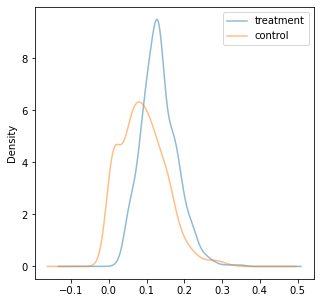

In [535]:
X=pdf_cox[(pdf_cox['HF_type_HF-REF']==1)].\
        drop(columns=["Smoking_status_Null","iptw",
                      "trial_startdate","patid",
                      "coronary_artery_bypass_graft","dialysis",
                      "HF_type_HF-REF",'HF_type_Null',
                      "Alcohol_consumption_1","Alcohol_consumption_2","Alcohol_consumption_Null"])


fig,ax=plt.subplots(figsize=(5,5))
X[X["treatment"]==1].propensity.plot.kde(bw_method=0.3,ax=ax,alpha=0.5,label='treatment')
X[X["treatment"]==0].propensity.plot.kde(bw_method=0.3,ax=ax,alpha=0.5,label='control')
plt.legend()
plt.show()

<AxesSubplot:>

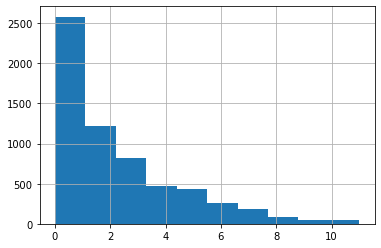

In [374]:
pdf_cox[pdf_cox['HF_type_HF-REF']==1]["Time_since_HF_diagnosis_yrs"].hist()

In [414]:
pdf_cox[(pdf_cox['HF_type_HF-REF']==0) & (pdf_cox["Time_since_HF_diagnosis_yrs"]>1 & (pdf_cox["Time_since_HF_diagnosis_yrs"]<3))].\
        drop(columns=["Smoking_status_Null","heart_valve_surgery","IBD","coronary_artery_bypass_graft","dialysis",
                      "trial_startdate","patid","Time_since_HF_diagnosis_yrs",
                      "HF_type_HF-REF",'HF_type_Null',
                      "alcoholism","Alcohol_consumption_1","Alcohol_consumption_2","Alcohol_consumption_Null",
                      "Year_2001","Year_2002","Year_2002","Year_2003","Year_2004"]).sum()

ACE                                               2.726700e+04
Amiloride                                         9.680000e+02
Anticoagulant                                     9.157000e+03
Antiplatelet                                      2.410000e+04
ARB                                               6.234000e+03
BB                                                9.573000e+03
Digoxin                                           1.063000e+04
Diuretic                                          3.508500e+04
Nitrates                                          1.511000e+04
Statins                                           1.493200e+04
Smoking_status_1                                  3.322000e+03
Smoking_status_2                                  1.768200e+04
NYHA_class_13189                                  2.980000e+02
NYHA_class_19066                                  1.680000e+02
NYHA_class_Null                                   3.570800e+04
BMI                                               9.779

In [425]:
pdf_cox[(pdf_cox['HF_type_HF-REF']==1) & (pdf_cox["Time_since_HF_diagnosis_yrs"]>1 & (pdf_cox["Time_since_HF_diagnosis_yrs"]<3))].\
        drop(columns=["Smoking_status_Null",
                      "trial_startdate","patid","Time_since_HF_diagnosis_yrs",
                      "coronary_artery_bypass_graft","dialysis",
                      "HF_type_HF-REF",'HF_type_Null',
                      "Alcohol_consumption_1","Alcohol_consumption_2","Alcohol_consumption_Null",
                      "Year_2001","Year_2002","Year_2002","Year_2003","Year_2004"]).sum()

ACE                                                 2659.000000
Amiloride                                             78.000000
Anticoagulant                                        814.000000
Antiplatelet                                        2257.000000
ARB                                                  634.000000
BB                                                  1284.000000
Digoxin                                              659.000000
Diuretic                                            3153.000000
Nitrates                                            1909.000000
Statins                                             1912.000000
Smoking_status_1                                     415.000000
Smoking_status_2                                    1416.000000
NYHA_class_13189                                      35.000000
NYHA_class_19066                                     145.000000
NYHA_class_Null                                     3342.000000
BMI                                     